# Clasificador de Tumores Cerebrales con CNN

##Abstract

Tumores cerebrales, además de ser uno de los tipos de tumores más comunes en niños, tienen relacionado gran parte de las muertes de cáncer en tanto niños como adultos jóvenes, puesto que estos son proporcionalmente más mortales que otros cánceres en relación a lo poco comunes que son. En el siguiente proyecto se va a explorar la detección de tumores cerebrales en imágenes por resonancia magnética (MRI, Magnetic Resonance Image, por sus siglas en inglés) a través de algoritmos de detección de imagen. El análisis manual de este tipo de imágenes involucra una gran inversión de tiempo y costo a través de los profesionales capacitados que se necesitan para desarrollarlo, mientras que a través del uso de algoritmos automatizados el análisis se podría realizar no solo de manera significativamente más rápida, sino que reduciendo el potencial error humano que involucra un análisis manual. A pesar de que hoy en día métodos automatizados para uso médico son comunes, el caso específico de segmentación de tumores cerebrales sigue siendo complejo dada la gran variedad de características que estos tienen, como su tamaño, forma y ubicación.

##Introducción

Los tumores cerebrales, además de ser uno de los tipos de tumores más comunes
en niños, tienen relacionado gran parte de las muertes de cáncer en tanto niños como adultos jóvenes [1], puesto que estos son proporcionalmente más mortales que otros cánceres en relación a lo poco comunes que son. En el siguiente proyecto se va a explorar la detección de tumores cerebrales en imágenes por MRI a través de algoritmos de detección de imagen. El análisis manual de este tipo de imágenes involucra una gran inversión de tiempo y costo a través de los profesionales capacitados que se necesitan para desarrollarlo, mientras que a través del uso de algoritmos automatizados el análisis se podría realizar no solo de manera significativamente más rápida, sino que reduciendo el potencial error humano. A pesar de que hoy en día métodos automatizados para uso médico son comunes, el caso específico de segmentación de tumores cerebrales sigue siendo complejo dada la gran variedad de características que estos tienen, como su tamaño, forma y ubicación [2]. El input del algoritmo son imágenes resultantes de resonancias magnéticas de cerebro, las cuales se ven sujetas a un preprocesamiento que mejora su calidad y las normaliza, para posteriormente, a partir de estas imágenes, se utilizó CNN para clasificar las imágenes entre cuatro categorías, cerebros con tumor del tipo glioma, meningioma, pituitario y cerebros sanos.

##Dataset y features

El dataset utilizado para el desarrollo del proyecto [3] contiene un total de 3.264 imágenes de resonancia magnéticas cerebrales etiquetadas en cuatro categorías: glioma, meningioma, pituitario y cerebros sanos. Se realizó de manera inicial un análisis descriptivo y exploratorio, los cuales se presentan a continuación.
En primer lugar se incorporó un análisis explotatorio de las dimensiones de las imágenes para determinar el formato original de estas.

In [ ]:
'''##Este código fue empleado de manera local, no en un servicio de la nube como lo es Colab, por lo que el formato de extracción de datos como
   ##la ubicación de la carpeta no es válido para este tipo de herramientas. Se presenta el código sólo de manera expositiva

   ##Análisis de dimensiones de las imágenes.
import os
from PIL import Image
import pandas as pd

def analizar_imagenes(carpeta):
    resultados = []

    print(f"Analizando la carpeta: {carpeta}")

    if not os.path.exists(carpeta):
        print(f"Error: La carpeta {carpeta} no existe.")
        return pd.DataFrame(resultados)

    try:
        archivos = os.listdir(carpeta)
        print(f"Total de archivos en la carpeta: {len(archivos)}")

        for archivo in archivos:
            print(f"Verificando archivo: {archivo}")
            if archivo.lower().endswith('.jpg'):
                ruta_completa = os.path.join(carpeta, archivo)
                print(f"Procesando archivo PNG: {ruta_completa}")
                try:
                    with Image.open(ruta_completa) as img:
                        ancho, alto = img.size
                        resultados.append({
                            'Archivo': archivo,
                            'Ancho': ancho,
                            'Alto': alto
                        })
                        print(f"Dimensiones de {archivo}: {ancho}x{alto}")
                except Exception as e:
                    print(f"Error al procesar {archivo}: {str(e)}")
            else:
                print(f"Ignorando archivo no PNG: {archivo}")

        print(f"Total de imágenes PNG procesadas: {len(resultados)}")
    except Exception as e:
        print(f"Error al leer la carpeta: {str(e)}")

    return pd.DataFrame(resultados)

# Especifica la ruta de la carpeta que contiene las imágenes PNG
carpeta = '/Users/apena/Desktop/BrainTumorDetectionProyect/glioma_tumor'

# Ejecuta el análisis
print("Iniciando análisis...")
df = analizar_imagenes(carpeta)

# Muestra los resultados
print("\nResultados:")
print(df)

# Guarda los resultados en un archivo CSV
csv_path = '/Users/apena/Desktop/BrainTumorDetectionProyect/dimensiones_glioma_tumor.csv'
try:
    df.to_csv(csv_path, index=False)
    print(f"\nLos resultados se han guardado en: {os.path.abspath(csv_path)}")
except Exception as e:
    print(f"Error al guardar el archivo CSV: {str(e)}")


Posteriormente se realizó un análisis descriptivo de las imágenes con las siguientes dos funciones. En primer lugar se manejan como matrices de intensidades de píxeles en donde en cada posición se tiene un valor, mientras menor sea este, más oscuro es el píxel que representa y viceversa con valores más altos. Al convertirlas en matrices en el cual se calculan estadísticas descriptivas sobre las imágenes y se grafican en un histograma con las intensidades de píxeles de las imágenes.

A continuación se presenta el código conslidado con la implementación de ambos procesos para cada imagen en cada categoría.


```
  def calculate_aggregated_statistics(images):
    """
    Calcula estadísticas agregadas para un conjunto de imágenes.
    """
    all_pixels = np.concatenate([img.ravel() for img in images])  # Unir píxeles
    media = np.mean(all_pixels)
    mediana = np.median(all_pixels)
    varianza = np.var(all_pixels)
    desviacion_estandar = np.std(all_pixels)
    coeficiente_variacion = desviacion_estandar / media if media != 0 else 0  # Manejar división por cero
    return {
        'media': media,
        'mediana': mediana,
        'varianza': varianza,
        'desviacion_estandar': desviacion_estandar,
        'coeficiente_variacion': coeficiente_variacion
    }
```



```
  def plot_pixel_intensity_histogram(images, category):
    """
    Genera y muestra un histograma de intensidades de píxeles para las imágenes de una categoría.
    """
    all_pixels = np.concatenate([img.ravel() for img in images])  # Unir píxeles de todas las imágenes
    plt.figure(figsize=(10, 4))
    plt.hist(all_pixels, bins=256, range=(0, 255), color='black', alpha=0.7)
    plt.title(f'Histograma de intensidades de píxeles - {category}')
    plt.xlabel('Intensidad del píxel')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
```


In [ ]:
'''##Este código fue empleado de manera local, no en un servicio de la nube como lo es Colab, por lo que el formato de extracción de datos como
   ##la ubicación de la carpeta no es válido para este tipo de herramientas. Se presenta el código sólo de manera expositiva

#Cálculo de estadísticas agregadas e histogramas de intensidades de píxeles
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Configuración inicial
IMG_SIZE = 512
DATA_DIR = '/Users/apena/Desktop/BrainTumorDetectionProyect/'  # Modificar con el propio path
CATEGORIES = {'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'}

def load_image(file_path):
    """
    Cargar y redimensionar la imagen.
    """
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Cargar como escala de grises
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

def calculate_aggregated_statistics(images):
    """
    Calcula estadísticas agregadas para un conjunto de imágenes.
    """
    all_pixels = np.concatenate([img.ravel() for img in images])  # Unir píxeles
    media = np.mean(all_pixels)
    mediana = np.median(all_pixels)
    varianza = np.var(all_pixels)
    desviacion_estandar = np.std(all_pixels)
    coeficiente_variacion = desviacion_estandar / media if media != 0 else 0  # Manejar división por cero
    return {
        'media': media,
        'mediana': mediana,
        'varianza': varianza,
        'desviacion_estandar': desviacion_estandar,
        'coeficiente_variacion': coeficiente_variacion
    }

def plot_pixel_intensity_histogram(images, category):
    """
    Genera y muestra un histograma de intensidades de píxeles para las imágenes de una categoría.
    """
    all_pixels = np.concatenate([img.ravel() for img in images])  # Unir píxeles de todas las imágenes
    plt.figure(figsize=(10, 4))
    plt.hist(all_pixels, bins=256, range=(0, 255), color='black', alpha=0.7)
    plt.title(f'Histograma de intensidades de píxeles - {category}')
    plt.xlabel('Intensidad del píxel')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def process_category(category):
    """
    Procesa las imágenes de una categoría, calcula estadísticas y genera un histograma.
    """
    path = os.path.join(DATA_DIR, category)
    images = []
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        image = load_image(img_path)
        images.append(image)

    # Calcular estadísticas agregadas
    aggregated_stats = calculate_aggregated_statistics(images)
    print(f"\nEstadísticas agregadas para {category}:")
    for stat_name, stat_value in aggregated_stats.items():
        print(f"  {stat_name}: {stat_value:.4f}")

    # Generar el histograma
    plot_pixel_intensity_histogram(images, category)

# Procesar categorías
for category in CATEGORIES:
    process_category(category)


##Metodologías

###Preprocesamiento de datos

El preprocesamiento realizado al dataset que se utilizará consta de tres fases. La fase inicial consta de un proceso de normalización que estandariza las dimensiones de las imágenes a 512x512 pixeles, y reescala los valores de la intensidad de los pixeles en una lógica de 0 a 1, en porcentaje de luminosidad por píxel, a una escala del 0 a 255.


```
def load_and_preprocess_image(file_path):
    # Cargar la imagen
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Normalizar las intensidades de los píxeles
    image = image / 255.0

    return image
```



A continuación, se convierten las imágenes a escala de grises, para luego encontrar los contornos más grandes de cada imagen, para de esta manera recortar los bordes negros característicos de las imágenes de resonancia magnética. Esto es, en esencia, para acercar la imagen, aumentando la proporción de cráneo a espacio vacío.

```
def crop_brain_contour(image):
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Umbralización
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Encontrar el contorno más grande
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Encontrar los puntos extremos
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Recortar la imagen
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

    return new_image
```

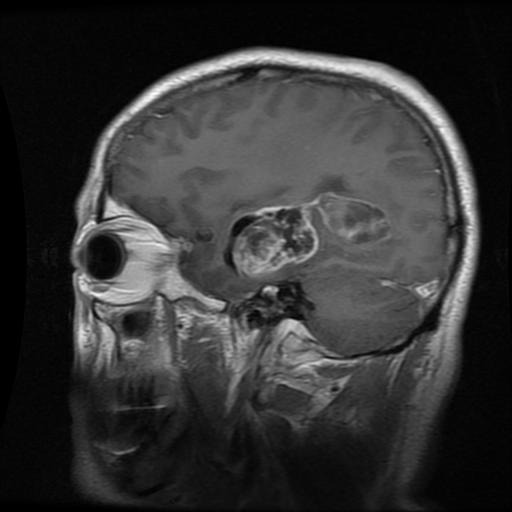

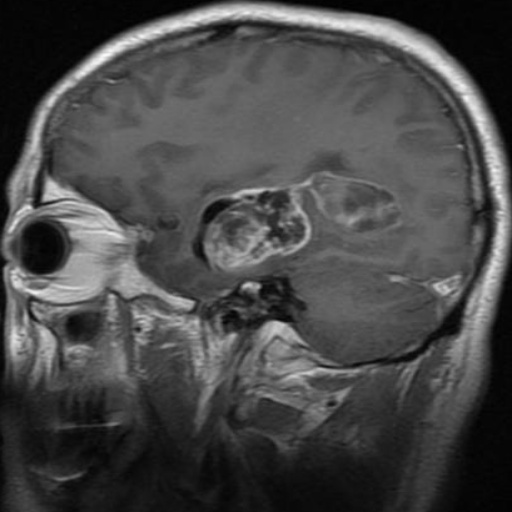

En la fase final, se incorpora un filtro Gaussiano [6], que suaviza las diferencias entre luminosidad de pixeles, reduciendo el impacto de valores atípicos externos.

```
image = gaussian_filter(image, sigma = 5)
```

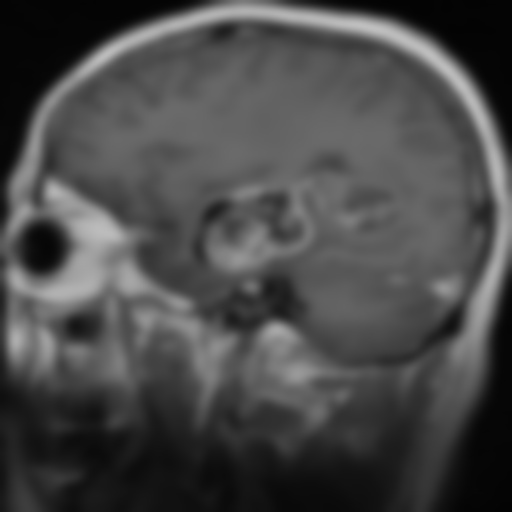

Este proceso es realizado iterativamente para cada una de las 3264 imágenes, a través del codigo consolidado presente a continuación.

In [ ]:
'''##Este código fue empleado de manera local, no en un servicio de la nube como lo es Colab, por lo que el formato de extracción de datos como
   ##la ubicación de la carpeta no es válido para este tipo de herramientas. Se presenta el código sólo de manera expositiva

   ##Preprocesamiento de imágenes

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import imutils
from scipy.ndimage import gaussian_filter

# Configuración inicial
IMG_SIZE = 512
CATEGORIES = {'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'}
DATA_DIR = '/Users/apena/Desktop/BrainTumorDetectionProyect/' #Modificar con el propio path

## Para ejecutar el código primeramente se debe modificar el propio path según corresponda.
# Además si se desea con filtro se debe comentar la línea correspondiente
# Iteramos una vez con filtro y otra sin ya que posteriormente compararemos los resultados de la clasificación

def load_and_preprocess_image(file_path):
    # Cargar la imagen
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Normalizar las intensidades de los píxeles
    image = image / 255.0

    return image

def calculate_aggregated_statistics(images):
    """
    Calcula estadísticas agregadas para un conjunto de imágenes de una categoría.
    """
    all_pixels = np.concatenate([img.ravel() for img in images])  # Unir los píxeles de todas las imágenes
    media = np.mean(all_pixels)
    mediana = np.median(all_pixels)
    varianza = np.var(all_pixels)
    desviacion_estandar = np.std(all_pixels)

    # Manejar el caso en que la media sea cero para evitar división por cero
    coeficiente_variacion = desviacion_estandar / media if media != 0 else 0
    return {
        'media': media,
        'mediana': mediana,
        'varianza': varianza,
        'desviacion_estandar': desviacion_estandar,
        'coeficiente_variacion': coeficiente_variacion
    }


def crop_brain_contour(image):
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Umbralización
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Encontrar el contorno más grande
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Encontrar los puntos extremos
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Recortar la imagen
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

    return new_image


def process_images(category):
    images = []
    path = os.path.join(DATA_DIR, category)
    #saveDir = os.path.join('/Users/apena/desktop/Preprocessed Data with Filter', category)
    saveDir = os.path.join('/Users/apena/desktop/Preprocessed Data', category)
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_and_preprocess_image(img_path)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = np.uint8(image)
        image = crop_brain_contour(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        ### Esta es la línea en la que se aplica el filtro###
        #image = gaussian_filter(image, sigma = 5)

        images.append(image)
        save_path = os.path.join(saveDir, img)
        cv2.imwrite(save_path, image)

        # Calcular estadísticas agregadas
    aggregated_stats = calculate_aggregated_statistics(images)

     # Imprimir estadísticas para esta categoría
    print(f"\nEstadísticas agregadas para {category}:")
    for stat_name, stat_value in aggregated_stats.items():
        print(f"  {stat_name}: {stat_value:.4f}")


    return np.array(images)

    # Procesar imágenes para cada categoría
processed_images = {category: process_images(category) for category in CATEGORIES}


# Visualizar 5 imágenes de cada categoría
def plot_images(images, category):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'{category} {i + 1}')
        #plt.title(f'{category} {i + 1} w/GF')
        plt.axis('off')
    plt.tight_layout()
    saveDir = os.path.join('/Users/apena/desktop/Preprocessed Data', category)
    #saveDir = os.path.join('/Users/apena/desktop/Preprocessed Data with Filter', category)
    save_path = os.path.join(saveDir, f'{category}_5Imagenes.jpg')
    #save_path = os.path.join(saveDir, f'{category} with Filter_5Imagenes.jpg')
    plt.savefig(save_path)
    plt.show()

for category, images in processed_images.items():
    plot_images(images, category)

    # Crear histograma de intensidades de píxeles por categoría
def plot_pixel_intensity_histogram(images, category):
    plt.figure(figsize=(10, 4))
    plt.hist(images.ravel(), bins=256, range=(0.0, 255.0), fc='k', ec='k')
    plt.title(f'Histograma de intensidades de píxeles - {category}')
    #plt.title(f'Histograma de intensidades de píxeles con filtro - {category}')
    plt.xlabel('Intensidad del píxel')
    plt.ylabel('Frecuencia')
    saveDir = os.path.join('/Users/apena/desktop/Preprocessed Data', category)
    #saveDir = os.path.join('/Users/apena/desktop/Preprocessed Data with Filter', category)
    save_path = os.path.join(saveDir, f'{category}_Histograma.jpg')
    #save_path = os.path.join(saveDir, f'{category} with Filter_Histograma.jpg')
    plt.savefig(save_path)
    plt.show()

for category, images in processed_images.items():
    plot_pixel_intensity_histogram(images, category)


print("Preprocesamiento completado. Las imágenes están listas para el entrenamiento.")

SyntaxError: incomplete input (<ipython-input-1-6040662d4353>, line 1)

###Medidas de desempeño

Para medir el desempeño del modelo, se plantean los siguientes indicadores, según [5]. Considerando TP como verdadero positivo (*True Positive*), TN como verdadero negativo (*True Negative*), FP como falso positivo (*False Positive*)
y FN como falso negativo (*False Negative*):



*   Accuracy o Exactitud, Se refiere a la exactitud, a la proporción de diagnósticos correctos como razón de los diagnósticos totales.

\begin{equation}
    \text{Accuracy} = \frac{T_P+T_N}{T_P+F_P+F_N+T_N}
\end{equation}


*   Precision o precisión mide la proporción de diagnósticos positivos correctos sobre el total de casos diagnosticados como positivos.

\begin{equation}
    \text{Precision} = \frac{T_P}{T_P + F_P}
\end{equation}

*   Recall o sensibilidad mide la frecuencia con que el modelo realizó una clasificación correcta de los casos positivos.

\begin{equation}
    \text{Recall} = \frac{T_P}{T_P + F_N}
\end{equation}


*   F-score, que combina precisión y sensibilidad, ofreciendo una visión complementaria para detectar correctamente cuando existen tumores en los MRI.


\begin{equation}
    \text{F-score} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\end{equation}












### Data Split en Training, Testing y Validation

La configuración de los datos de entrenamiento se realizará siguiendo una lógica de trabajo en la nube. En este sentido se detallará a continuación la manipulación de los datos previo a su uso en el modelo.

En primer lugar, se implementará el desarrollo del presente trabajo utilizando principalmente la librería TensorFlow, la cual tiene todos los métodos necesarios para la construcción de la CNN.

```
import tensorflow as tf
```

Adicionalmente, por decisiones de diseño y facilidad en la ejecución se debe verificar que la versión actual de TensorFlow tenga incorporada la funcionalidad CUDA, la cual permite la ejecución de los bloques de código con una GPU externa, una funcionalidad de Google Colab que permite utilizar cloud computing mejorando dramáticamente los tiempos de ejecución.


```
print(tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
tf.config.list_physical_devices('GPU')
```

Se importan además las librerías necesarias para la carga y manipulación de las imágenes, que son estándar para la mayoría de los proyectos de Machine Learning con Python.

En particular, para la posterior segmentación del conjunto de datos en training, testing y validation, se implementará la librería sklearn con su respectivo método train_test_split

```
from sklearn.model_selection import train_test_split
```

Finalmente fijamos una semilla para garantizar la reproducibilidad de los resultados obtenidos, particularmente al segmentar el conjunto de datos entre training y testing. Esto debido a que el método seleccionado, permite incorporar una partición de los datos aleatorizada con la semilla elegida.

Para esto son necesarias las siguientes librerías

In [ ]:
# TensorFlow framework
import tensorflow as tf
print(tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
tf.config.list_physical_devices('GPU')

# Data frame and Data Handling
import numpy as np # Para manejo eficiente de arreglos y matrices
import pandas as pd # Para leer y crear datasets.

# Visualization
import seaborn as sns # Para visualización de datos con interfaces de alto nivel
import cv2 # Para leer, escribir y mostrar imagenes de openCV
import matplotlib.pyplot as plt # Para mostrar gráficos e imágenes con ejes

# Dataset splitting
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Other
import random # Ocupado para fijar una semilla
import os # Ocupado para navegar entre directorios de archivos
from collections import Counter # Ocupado para contar imágenes de un conjunto

# Set a seed for reproducibility
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Verify seed setting
print("Seed set for reproducibility:", SEED)

2.17.1
Built with CUDA: True


En particular la asignación de categorías requiere de un tratamiento especial ya que se pueden referenciar con una equivalencia en índices. Sin embargo, para la correcta ejecución del código se implementa una forma de etiquetar llamada one-hot encode label que se diferencia por representar de 4 categorías la primera como [1,0,0,0], la segunda como [0,1,0,0] y así sucesivamente.
El código que permite esto es el siguiente.

```
from tensorflow.keras.utils import to_categorical
```


Los conjuntos de datos preprocesados fueron subidos a una página web con el fin de facilitar su carga en el entorno de Google Colab. Las siguientes líneas de código se encargan de subir la base de datos y de descomprimir el archivo zip en el que están almacenadas.

Existen dos archivos, uno con los datos con el preprocesamiento aplicado y con el filtro y otro archivo con el preprocesamiento expectuando la aplicación del filtro gaussiano, respectivamente:

*   "*./BrainTumorDetectionProyect/Preprocessed Data with Filter*"
*   "*./BrainTumorDetectionProyect/Preprocessed Data*"

A continuación se puede modificar el DATA_DIR si se quisiera correr el código en manera diferenciada.



```
DATA_DIR = "./BrainTumorDetectionProyect/Preprocessed Data"
```






In [ ]:
![[ -f BrainTumorDetectionProyect.zip ]] || curl https://krr.cl/alonso/BrainTumorDetectionProyect.zip -O
![[ -d BrainTumorDetectionProyect ]] || unzip BrainTumorDetectionProyect.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/m1(145).jpg  
  inflating: __MACOSX/BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/._m1(145).jpg  
  inflating: BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/m3 (53).jpg  
  inflating: __MACOSX/BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/._m3 (53).jpg  
  inflating: BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/m2 (53).jpg  
  inflating: __MACOSX/BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/._m2 (53).jpg  
  inflating: BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/m (193).jpg  
  inflating: __MACOSX/BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/._m (193).jpg  
  inflating: BrainTumorDetectionProyect/Base Bruta/Training/meningioma_tumor/m1(58).jpg  
  inflating: __MACOSX/BrainTumorDetectionProyect/Base Bruta/Training/me

In [ ]:
# Define the paths and categories
DATA_DIR = "./BrainTumorDetectionProyect/Preprocessed Data with Filter"
CATEGORIES = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Confirm paths and categories are correctly set
print("Data Directory:", DATA_DIR)
print("Categories:", CATEGORIES)

Data Directory: ./BrainTumorDetectionProyect/Preprocessed Data with Filter
Categories: ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']


En los siguientes bloques de código se le debe asignan las etiquetas a las imágenes dependiendo del conjunto al que pertenzcan. Este proceso se realiza para cada una de las imágenes pertenecientes a cada una de las 4 categorías.
Para verificar que el proceso se ha realizado de buena manera se recuentan las imágenes y las etiquetas.

Además se vuelve a presentar el detalle de ejemplares por categoría y se selecciona una muestra de 5 imágenes por cada categoría con su respectiva etiqueta asignada, tanto en número como en nombre.

Loaded images: 3264
Loaded labels: 3264


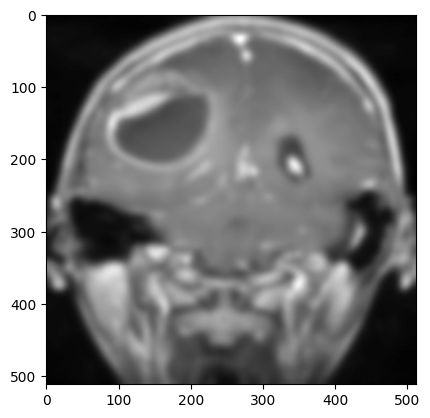

In [ ]:
# Function for loading images and assigning labels
def load_images(data_dir, categories):
    images = []
    labels = []
    for category in categories:
        folder_path = os.path.join(data_dir, category)
        label = categories.index(category)  # Encode label as an integer based on index
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #Preprocessing made for grayscale
            if image is not None:
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(DATA_DIR, CATEGORIES)
plt.imshow(images[0], cmap='gray')


# Confirm loading was successful
print("Loaded images:", len(images))
print("Loaded labels:", len(labels))

Total images loaded: 3264
Total labels loaded: 3264

Image counts per category:
glioma_tumor: 926 images
no_tumor: 500 images
meningioma_tumor: 937 images
pituitary_tumor: 901 images


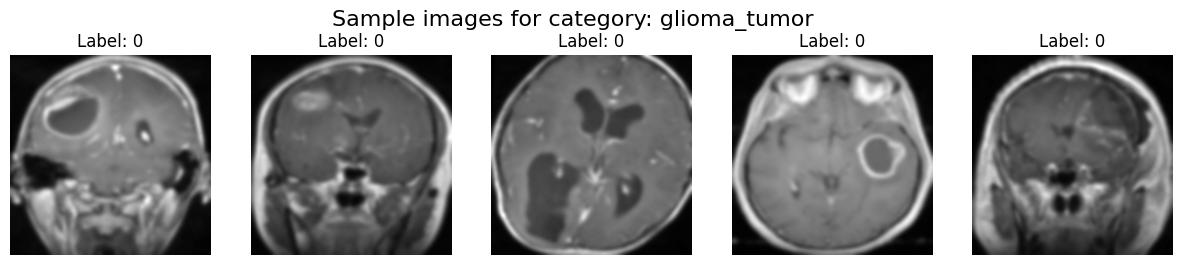

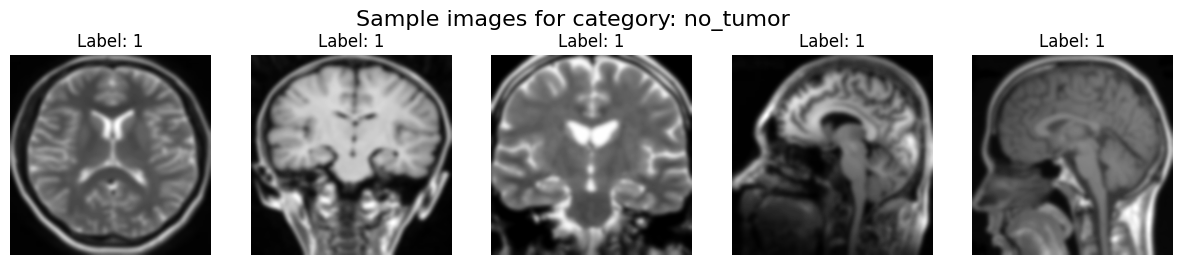

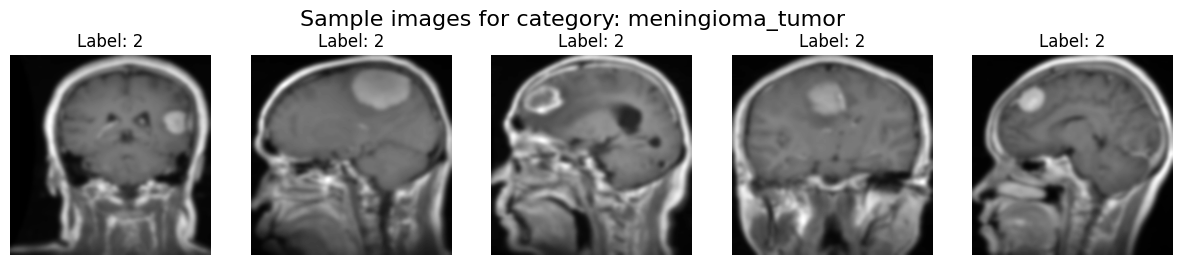

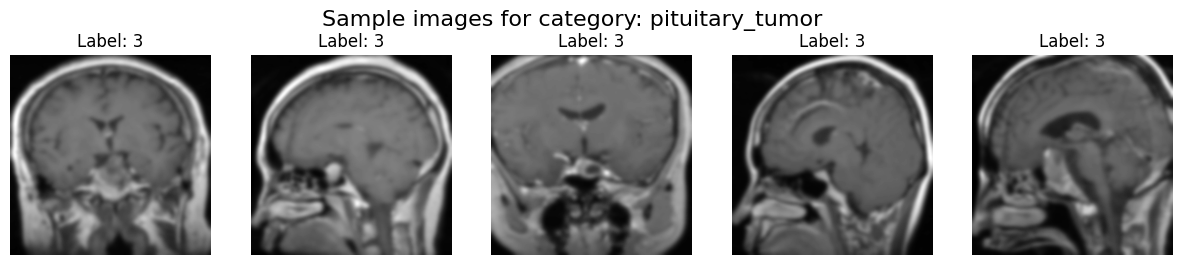

In [ ]:
# Load images and labels
images, labels = load_images(DATA_DIR, CATEGORIES)

# Confirm loading was successful
print("Total images loaded:", len(images))
print("Total labels loaded:", len(labels))

# Check distribution of labels to confirm they match categories
label_counts = Counter(labels)
print("\nImage counts per category:")
for category, label in zip(CATEGORIES, range(len(CATEGORIES))):
    print(f"{category}: {label_counts[label]} images")

# Function to display a few sample images from each category
def display_sample_images(images, labels, categories, num_samples=5):
    # Loop over each category
    for category_idx, category_name in enumerate(categories):
        # Find indexes of images with current label
        category_images = [img for img, label in zip(images, labels) if label == category_idx]

        # Display only the specified number of samples (e.g., 5)
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Sample images for category: {category_name}", fontsize=16)
        for i in range(min(num_samples, len(category_images))):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(category_images[i], cmap='gray')
            plt.title(f"Label: {category_idx}")
            plt.axis('off')
        plt.show()

# Call the function to display images and labels for each category
display_sample_images(images, labels, CATEGORIES)

Finalmente se segmenta la base de datos en 60% para entrenamiento, 20% para prueba y 20% para validación. Esto se consigue aplicando secuencialmente la función train_test_split dejando 40% para testing y de ese porcentaje asignar el 50% (i.e. 20% de la base original) para validación.

In [ ]:
# Load images and labels
images, labels = load_images(DATA_DIR, CATEGORIES)
# One-hot encode labels (apply after loading)
categorical_labels = to_categorical(labels, num_classes=4)  # Assuming 4 classes

# Split data into training, validation, and test sets (e.g., 60% train, 20% val, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, categorical_labels, test_size=0.4, random_state=SEED, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

# Display the split sizes
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (1958, 512, 512)
Validation set size: (653, 512, 512)
Test set size: (653, 512, 512)


###Redes convolucionales

En el nivel más abstracto, las CNN (Convolutional Neural Networks) son algoritmos de clasificación de imágenes, que a partir de la construcción de una matriz de intensidades de píxeles,
logran la identificación de features característicos de los registros analizados. En este caso particular, se busca entrenar una red que clasifique las imágenes de MRI según el tipo de tumor. [4]

A diferencia de los típicos algoritmos de Machine Learning que trabajan con la imagen como vector de intensidades de píxeles, la innovación de las CNN es que trabajan matricialmente conservando
la espacialidad de las características relevantes para la correcta identificación de la categoría.

Las librerías necesarias para desarrollar un modelo de este tipo son:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

Los algoritmos se dividen en cuatro partes principalmente, las Capas convolucionales, las Capas de pooling, una capa de neuronas densas *Fully Connected* y las neuronas de clasificación en la útlima etapa.

De manera general, para desarrollar las capas convolucionales se aplica un filtro Kernel o matriz de convolución, es decir, es un tratamiento a una matriz con coeficientes [7].
La dimensionalidad del Kernel es fijada como hiperparámetro y se realiza una cantidad determinada de veces (también hiperparámetro), generando como resultado, tantas imágenes como kernels
se hayan aplicado. Los valores dentro de esta matriz, se determinan durante el entrenamiento y se conocen como “feature map”, ayudan a identificar patrones específicos en la imagen, como bordes, texturas o formas.

  
```
Conv2D(N° Filtros, (nfilKernal, ncolKernel), activation='funcion_activación', input_shape=(anchoPixeles, altoPixeles, N°canales), padding='same'),
```
   
En segundo lugar, se utilizaron Capas de Pooling, las cuales reducen la dimensionalidad de las imágenes generadas, mediante un kernel, cuyas dimensiones se especifican por parámetro, manteniendo las características más relevantes.

```
MaxPooling2D(pool_size=(nfilKernal, ncolKernel))
```


A continuación, se ocupó Batch normalization, técnica que ajusta automáticamente los valores de los Kernel de la red en cada feature map para que tengan una media y una varianza consistentes.
Esto ayuda a que el entrenamiento de la CNN sea más rápido y estable.

```
BatchNormalization(),
```

Posteriormente la imagen se comprime a un vector luego de haber sido procesada, mediante la funcion Flatten, en última instancia se pasa por capas de neuronas completamente conectadas a las capas anteriores, esta etapa se le denomina Dense Layers. En particular estamos usando la función ReLU, la cual permite realizar asociaciones no lineales entre neuronas.

```
Flatten()
Dense(N° neuronas, activation='función_activación')
```


Por último, se implementa una función adicional denominada Dropout, la cual, desactiva neuronas específicas con una probabilidad dada por parámetro de tal manera que el resultado que arroje la clasificación no dependa de neuronas específicas.

```
Dropout(Prob_desactivar_neurona)
```

En más detalle, la configuración de hiperparámetros utilizada, fue la misma del estudio de Khaliki M. Z. y Başarsian, M.S. [5]. Posteriormente debido a los mejores desempeños alcanzados, se decidió optar por la propuesta por Saeedi et al. [8], la cual es presentada a continuacion. En función de su configuración de hiperparámetros se establece el número de capas de convolución y Pooling, la dimensionalidad de los filtros Kernels y las funciones al interior de las neuronas que serán detalladas a continuación.

En particular la implementación comporta un input de 3264 imágenes de dimensionalidad 512x512 píxeles en 1 canal (i.e. blanco y negro). Se aplican capas convolucionales secuenciales, en particular para cada etapa, dos capas de 64 filtros, es decir, se generan 64 imágenes por etapa con un Kernel de 2x2.
Luego, éstas son separadas por una etapa de Batch normalization que termina con un Max pooling con Kernel de 2x2 lo que quiere decir que se aplica en zancadas de 2 píxeles y en cada una se elige el píxel con mayor intensidad y un dropout con una probabilidad de 0,1.

```
# First Block
    Conv2D(64, (2, 2), activation='relu', input_shape=(512, 512, 1), padding='same'),
    BatchNormalization(),
    Conv2D(64, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
```


Este proceso se realiza iterativamente para capas con 32, 16 y 8 filtros. Seguido, se encuentra una capa de pooling, siguiendo el método Max Pooling con un kernel de 2x2.


```
    # Second Block
    Conv2D(32, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Third Block
    Conv2D(16, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(16, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Fourth Block
    Conv2D(8, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(8, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
```



Una vez que las imágenes fueron generadas y procesadas, se comprimen en forma de vector con la función Flatten() para ser alimentadas a la capa fully connected de neuronas convencionales.

Luego, se pasa a una fase con 1024 neuronas con función de activación ReLU, que permite realizar asociaciones no lineales. Se complementa con la aplicación de la función Dropout. La última etapa consta de 4 neuronas, las cuales representan las 4 categorías de tumores; Se implementan mediante la función Softmax la cual decide qué categoría pertenece a cada imagen basándose en la más alta probabilidad.

```
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')  # 4 output classes
```

De manera adicional a la arquitectura estándar de la CNN, para optimizar el aprendizaje de la CNN se utiliza Adam (por sus siglas en inglés, Adaptive Moment Estimation), ampliamente utilizado en este tipo de redes porque combina eficiencia computacional, buen manejo de gradientes dispersos, y adaptabilidad en la actualización de los pesos. A grandes rasgos, funciona ajustando los pesos del modelo, es decir, los valores del Kernel en las capas convolucionales, durante el entrenamiento de forma dinámica y eficiente. Utiliza promedios de los gradientes (dirección de ajuste) y de sus cuadrados (magnitud de ajuste) para adaptar automáticamente la tasa de aprendizaje de cada peso, lo que acelera la convergencia y mejora la estabilidad del entrenamiento [10].

```
optimizer=Adam(learning_rate=0.001)
```

En última instancia, se implementa el callback ReduceLROnPlateau, la cual ajusta la tasa de aprendizaje cuando la pérdida de validación no mejora. Esto permite estabilizar el aprendizaje en las últimas etapas de entrenamiento.


```
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
```

Finalmente, la arquitectura de la CNN queda de la siguiente manera:


In [ ]:
# 2D CNN Architecture from the Paper
model = Sequential([
    # First Block
    Conv2D(64, (2, 2), activation='relu', input_shape=(512, 512, 1), padding='same'),
    BatchNormalization(),
    Conv2D(64, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Second Block
    Conv2D(32, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Third Block
    Conv2D(16, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(16, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Fourth Block
    Conv2D(8, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(8, (2, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Fully Connected Layers
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Model summary to confirm the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      320       
                                                                 
 batch_normalization (Batch  (None, 512, 512, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      16448     
                                                                 
 batch_normalization_1 (Bat  (None, 512, 512, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                        

In [ ]:
# Set up ReduceLROnPlateau as a callback to adjust learning rate during training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# Training configuration
# Callbacks and model fitting
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=15,
                    callbacks=[reduce_lr])

Epoch 1/20
131/131 [==============================] - 123s 837ms/step - loss: 2.1942 - accuracy: 0.5638 - precision: 0.5814 - recall: 0.5123 - val_loss: 1.6262 - val_accuracy: 0.3553 - val_precision: 0.3769 - val_recall: 0.3093 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 109s 829ms/step - loss: 0.6182 - accuracy: 0.7743 - precision: 0.8038 - recall: 0.7365 - val_loss: 1.0285 - val_accuracy: 0.6371 - val_precision: 0.6758 - val_recall: 0.5651 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 109s 831ms/step - loss: 0.3822 - accuracy: 0.8626 - precision: 0.8803 - recall: 0.8453 - val_loss: 0.8453 - val_accuracy: 0.7489 - val_precision: 0.7656 - val_recall: 0.7351 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 109s 831ms/step - loss: 0.2204 - accuracy: 0.9249 - precision: 0.9301 - recall: 0.9173 - val_loss: 0.8049 - val_accuracy: 0.7596 - val_precision: 0.7750 - val_recall: 0.7489 - lr: 0.0010
Epoch 5/20
131/131 [================

###Resultados de la CNN custom

Con la arquitectura de la CNN establecida, y el modelo entrenado, es necesario ahora obtener las métricas de desempeño relevantes. Esto se hace, a partir de las métricas definidas anteriormente, con el siguiente código y librerias.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


La porción de código a continuación calcula las cuatro métricas de desempeño que definimos, las cuales luego grafica en una matriz de confusión que compara la etiqueta predecida por el modelo versus la etiqueta real de la imagen.

21/21 [==============================] - 9s 271ms/step
Accuracy: 0.8208269525267994
Precision: 0.8201639212613738
Recall: 0.8208269525267994
F1 Score: 0.8190240706305363


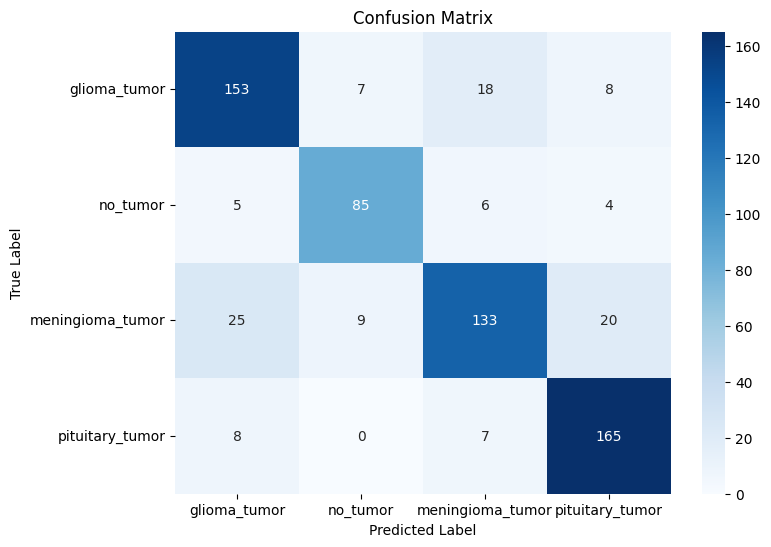

In [ ]:
# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)  # Convert probabilities to class labels
y_pred_labels = to_categorical(y_pred_labels, num_classes=4)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

# Print the calculated metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_labels, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Finalmente, se desarrolla un código que grafique las curvas ROC, o Receiver Operating Characteristic curve de cada una de las categorías. Cada una de estas curvas va a representar la proporción de verdaderos positivos versus falsos positivos, por lo que mejores curvas ROC (gráficamente, más cercanas a la esquina superior izquierda) representarán una mejor capacidad del modelo para identificar correctamente positivos. Esto, además, se acompaña de un cálculo del área bajo la curva (AUC) que nos permite cuantificar el desempeño que muestra las curvas ROC.

21/21 [==============================] - 4s 198ms/step


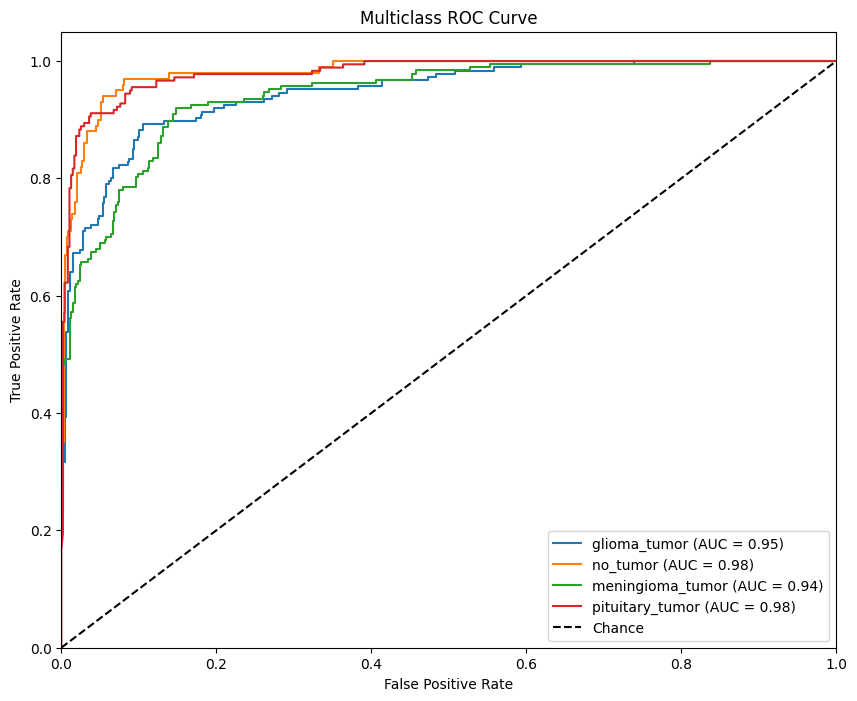

In [ ]:
# Step 1: Binarize the labels for the test set (y_test) to make them suitable for multiclass ROC calculation
n_classes = len(CATEGORIES)  # Number of classes (4 in your case)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))  # Convert integer labels to binary (one-hot) format

# Step 2: Get predicted probabilities from the model
y_pred = model.predict(X_test)  # Predicted probabilities for each class

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    # Calculate the ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CATEGORIES[i]} (AUC = {roc_auc:.2f})")  # Use category names for each curve

# Plot the "chance" line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Diagonal line for random guessing

# Step 4: Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()



###Transfer learning y VGG16

Finalmente, para establecer un punto de comparativa a la red neuronal entrenada planteada en el punto anterior, se aplica también el transfer-learning. Esta
metodología consiste en aplicar en modelos pre-entrenados con datasets no necesariamente relacionados al que finalmente utilizará, el cual luego es fine-tuned para alcanzar mejores precisiones y desempeños que modelos entrenados tradicionalmente [11]. Se eligió particularmente la VGG16, debido a los excelentes resultados que presentó para Khaliki M. Z. y Başarsian, M.S. [5]

La VGG16 es una arquitectura de CNN introducida en 2014, que consta de 16 capas en total, con 13 convolucionales de filtros pequeños (3x3) seguidas de sus respectivas capas de pooling para reducir dimensiones, y 3 fully connected para la clasificación final. Aunque requiere comporta un alto costo computacional, tiene una arquitectura simple y que arroja buenos resultados. Las librerías necesarias, y su arquitectura, se presentan a continuación [12]


```
from tensorflow.keras.applications import VGG16
```

Al igual que en el caso anterior, con la aplicación de la Custom CNN se presentará las librerías necesarias para la implementación de la VGG 16, el cálculo de las medidas de desempeño puntuales descritas anteriormente y globales con el área bajo la curva ROC.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# Input Layer to handle 1-channel (grayscale) images
input_layer = Input(shape=(512, 512, 1))  # Input shape as (512, 512, 1)

# Convert grayscale to RGB (3 channels)
conv_layer = Conv2D(3, (3, 3), padding='same')(input_layer)

# Load VGG16 base model with pre-trained ImageNet weights, excluding the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
vgg16_base.trainable = False  # Freeze the base model to avoid training its weights

# Pass the output of Conv2D to the VGG16 base model
vgg16_features = vgg16_base(conv_layer)

# Add custom layers on top of VGG16 base
pooling_layer = GlobalAveragePooling2D()(vgg16_features)
dense_layer = Dense(128, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.05)(dense_layer)
output_layer = Dense(4, activation='softmax')(dropout_layer)  # Output for 4 classes

# Create the final model
vgg16_model = Model(inputs=input_layer, outputs=output_layer)

# Configure optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Display model summary
vgg16_model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 512, 512, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0      

Con la arquitectura de la red VGG16 ya planteada, se implementa nuevamente el método ReduceLROnPlateau, integrando los callbacks para modificar la tasa de aprendizaje según se describió anteriormente, y se entrena el modelo con la base de datos ya subida.

In [ ]:
# Set up ReduceLROnPlateau as a callback to adjust learning rate during training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# Directly use the X_train, X_val, and X_test from custom CNN
def train_model():
    history = vgg16_model.fit(
        X_train, y_train,  # Training data (grayscale images and labels)
        validation_data=(X_val, y_val),  # Validation data
        epochs=20,  # Number of epochs
        batch_size=15,
        callbacks=[reduce_lr]  # Include learning rate adjustment callback
    )
    return history

# Train the VGG16 model
history = train_model()

Epoch 1/20
131/131 [==============================] - 130s 859ms/step - loss: 0.9554 - accuracy: 0.5991 - precision_1: 0.7182 - recall_1: 0.4530 - val_loss: 0.6835 - val_accuracy: 0.7580 - val_precision_1: 0.8180 - val_recall_1: 0.6539 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 109s 837ms/step - loss: 0.6404 - accuracy: 0.7671 - precision_1: 0.8170 - recall_1: 0.7002 - val_loss: 0.6614 - val_accuracy: 0.7580 - val_precision_1: 0.7924 - val_recall_1: 0.7014 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 110s 837ms/step - loss: 0.5229 - accuracy: 0.8121 - precision_1: 0.8472 - recall_1: 0.7702 - val_loss: 0.5382 - val_accuracy: 0.7902 - val_precision_1: 0.8370 - val_recall_1: 0.7626 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 103s 785ms/step - loss: 0.4791 - accuracy: 0.8284 - precision_1: 0.8575 - recall_1: 0.7840 - val_loss: 0.5714 - val_accuracy: 0.8009 - val_precision_1: 0.8301 - val_recall_1: 0.7779 - lr: 0.0010
Epoc

### Resultados de VGG16


Los resultados de la red implementada por transfer learning se miden de la misma manera que aquellos de la custom CNN.

21/21 [==============================] - 22s 1s/step
Accuracy: 0.8468606431852986
Precision: 0.8501754835119233
Recall: 0.8468606431852986
F1 Score: 0.847363115698648


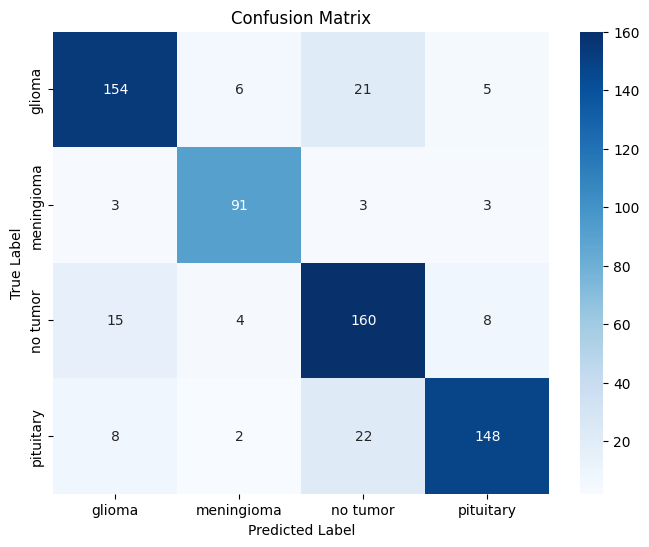

In [ ]:
# Predict labels for the test set using the VGG16 model
y_pred = vgg16_model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded y_test to label encoded form if necessary
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class labels if y_test is one-hot encoded

# Calculate performance metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Print the calculated metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Ensure CATEGORIES is defined with your class names
CATEGORIES = ['glioma', 'meningioma', 'no tumor', 'pituitary']

# Plot the confusion matrix with category names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


21/21 [==============================] - 14s 681ms/step


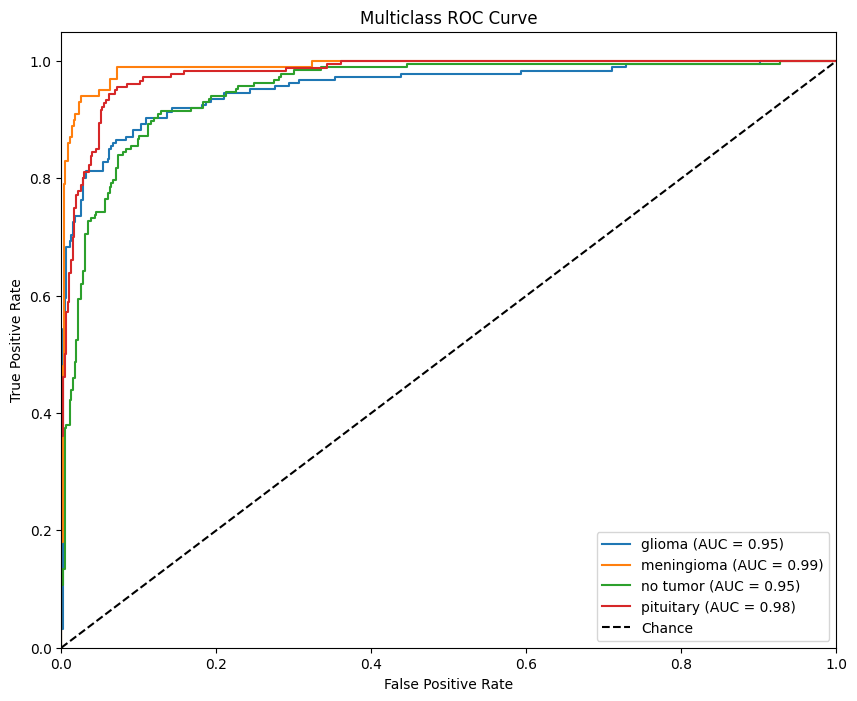

In [ ]:
# Step 1: Binarize the labels for the test set (y_test) to make them suitable for multiclass ROC calculation
n_classes = len(CATEGORIES)  # Number of classes (4 in your case)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))  # Convert integer labels to binary (one-hot) format

# Step 2: Get predicted probabilities from VGG16 model
y_pred = vgg16_model.predict(X_test)  # Predicted probabilities for each class

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    # Calculate the ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CATEGORIES[i]} (AUC = {roc_auc:.2f})")  # Use category names for each curve

# Plot the "chance" line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Diagonal line for random guessing

# Step 4: Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()


## Análisis de resultados

La implementación del modelo se realizó sobre las imágenes con filtro gaussiano aplicado  en la red neuronal a medida (Custom CNN) y posteriormente se alimentaron los mismos datos a la CNN pre entrenada VGG16.

Se utilizan medidas clásicas de desempeño como accuracy, precisión, recall y F1-Score, además de una matriz de confusión que grafica las categorías predecidas y las categorías reales sobre un mapa de calor para identificar la proporción de predicciones correctas y poder identificar posibles confusiones.

El análisis se centró principalmente en el área bajo la curva (AUC) ROC (Receiver Operating Characteristic, según sus siglas en inglés), la cual determina la tasa entre verdaderos y falsos positivos a medida que se ajustan los parámetros de clasificación. La interpretabilidad de la AUC es la capacidad del modelo de distinguir entre categorías.

A partir de los resultados obtenidos del testing en la clasificación de tumores de la Custom CNN (La construida a partir de la configuración encontrada en la literatura) y el resultado de la aplicación de Transfer Learning con la red pre entrenada VGG16 se realiza una comparativa de los desempeños.

Para las métricas de desempeño puntuales se observa que la red VGG16 presenta un mejor desempeño en todas ellas respecto a la red construida. Al analizar la matriz de confusión en detalle se puede observar que la Custom CNN presenta un buen desempeño para clasificar las clases glioma y pituitary tumor, mas tiende a confundir las clases meningioma con glioma y viceversa. La red VGG16 genera una mejora significativa en la detección de las imágenes sin tumor y la detección de meningioma tumor, sin embargo comete más errores respecto a la Custom CNN en las clases de glioma y pituitario.  

Si analizamos las métricas de desempeño global, es decir el área bajo la curva Receiving Operator (AUC-ROC), vemos que ambas redes presentan rendimientos similares pero la red VGG16 converge más rápidamente a las predicciones reales, es decir, se apega a la esquina superior izquierda, lo que es un rasgo deseable en estas curvas. Se puede interpretar como que la tasa de verdaderos positivos aumenta rápidamente con un leve aumento de los falsos positivos, demostrando una menor frecuencia de diagnósticos equivocados. Esto también se evidencia en el incremento de las medidas de desempeño puntales. En particular entrega valores de AUC superiores a aquellos entregados por la Custom CNN aunque ambos presentan valores sobre 0,95.

Un factor que no se puede dejar de lado es el hecho de que, a pesar de que el código se construyó desde cero utilizando las configuraciones y arquitecturas presentadas por [12] y [13], no se alcanzó los mismos niveles de rendimiento que estos alcanzaban independiente de en cuál de las dos arquitecturas la red personalizada se usase como base en cada prueba. Con todos los otros factores iguales (arquitectura, filtros e hiper parámetros), el único factor que podría implicar variabilidad en los resultados es la base de datos que se utiliza, y el cómo esta fue particionada para entrenamiento, prueba y validación. Originalmente, la base de datos que fue utilizada para efectos de esta investigación (y que además fue utilizada para las dos investigaciones en las que esta se basó) venía pre-dividida entre una sección para entrenamiento y prueba, y otra para la validación. Para efectos de esta investigación, al buscar incorporar una fase de preprocesamiento, se decidió reagrupar estas imágenes previamente divididas, para poder aplicar técnicas como el filtro gaussiano y luego seleccionar una muestra aleatoria de validación. Esto da lugar a dos hipótesis posibles para poder explicar estas diferencias no insignificantes de desempeño: que el preprocesamiento de imágenes no haya sido efectivo sino que fue perjudicial para la habilidad de la red de identificar imágenes, o bien que la preselección de imágenes fue seleccionada buscando las de mejor calidad para el conjunto de validación. Se intentó verificar la primera hipótesis, entrenando la red con imágenes con y sin preprocesamiento aplicado, y se siguió sin alcanzar los valores planteados por ninguno de los autores.



##Limitaciones

Dada la alta resolución de las imágenes en comparación con otros estudios y la alta cantidad de samples en el conjunto de datos, la etapa de entrenamiento del modelo se volvía excesivamente costosa para los procesadores de los computadores portátiles que se tenían a disposición. Es por esto que se decidió migrar la implementación a Google Colab, con el fin de utilizar una GPU externa para poder entrenar el modelo en intervalos de tiempo razonables, mejorando dramáticamente en este aspecto. Sin embargo, dadas las limitaciones del plan gratuito, en términos de capacidad RAM del sistema y de la GPU, no permitieron la implementación de todas las recomendaciones realizadas para mejorar las métricas de desempeño que serán detalladas en el siguiente apartado.

##Trabajo futuro

Las recomendaciones para aumentar las métricas de desempeño del modelo incluyen un proceso de Data Augmentation que incluya rotaciones, traslaciones y zooms en las imágenes de entrenamiento para que la CNN se pueda entrenar con un conjunto de datos más heterogéneo. De esta manera, se puede solventar la limitación común en los modelos de Deep Learning, hasta cierto punto, en que sus predicciones son fuertemente dependientes del conjunto de datos con el cual se entrenó.

En particular dada la dificultad del modelo para distinguir entre las imágenes con las etiquetas de glioma_tumor y meningioma_tumor se podría aplicar además Data Augmentation focalizado para dichas clases, de tal manera aplicar un oversampling con variaciones en las imágenes para probar si mejora la predicción de las clases.

Finalmente para la validación de los resultados se recomienda la implementación de una validación cruzada en la que el conjunto de datos se divide en un número determinado de particiones con las se seleccionan n -1 para el entrenamiento y la adicional se ocupa para la prueba. Esto se realiza iterativamente n - 1 veces para probar con todas las combinaciones de conjunto de entrenamiento y testeo. Finalmente se promedian las métricas de desempeño de cada una de las iteraciones y se obtienen métricas globales, otorgando una mayor robustez a los resultados volviéndolas más independientes del conjunto de entrenamiento particular.

##Bibliografía

[1] Katharine A McNeill. “Epidemiology of brain tumors”. In: Neurologic clinics 34.4. 2016. pp. 981–998. DOI: https://doi.org/10.1002/cncr.23741

[2] Javaria Amin et al. “Brain tumor detection using statistical and machine learning method”. In: Computer methods and programs in biomedicine 177. 2019. pp. 69–79. DOI: https://doi.org/10.1016/j.cmpb.2019.05.015

[3] Sartaj Bhuvaji et al. Brain Tumor Classification (MRI). DOI: https://doi.org/10.34740/KAGGLE/DSV/1183165. URL: https://www.kaggle. com/dsv/1183165.

[4] Sakshi Indolia et al. “Conceptual understanding of convolutional neural network-a deep learning approach”. In: Procedia computer science 132. 2018. pp. 679–688. DOI: https://doi.org/10.1016/j.procs.2018.05.069

[5] Mohammad Zafer Khaliki and Muhammet Sinan Ba¸sarslan. “Brain tumor detection from images and comparison with transfer learning methods and 3-layer CNN”. In: Scientific Reports 14.1. 2024. p. 2664.DOI: https://doi.org/10.1038/s41598-024-52823-9

[6] Kelton Waltz and Andrés González. “Desmitificación del desenfoque gaussiano” In: Adobe. 2024. URL: https://www.adobe.com/cl/creativecloud/photography/discover/gaussian-blur.html

[7] Giménez Palomares et al. “Aplicación de la convolución de matrices al filtrado de imágenes” In: Modelling in Science Education and Learning. DOI: https://doi.org/10.4995/msel.2016.4524

[8] Saeedi et al. “MRI-based brain tumor detection using convolutional deep learning methods and chosen machine learning techniques” In: BioMed Central. 2023. DOI: https://doi.org/10.1186/s12911-023-02114-6

[9] In: Computer Science Wiki. “MaxpoolSample2” URL:  https://computersciencewiki.org/index.php/File:MaxpoolSample2.png

[10] Diederik P. Kingma and Jimmy Ba. “Adam: A Method for Stochastic Optimization” In: arXiv . Ene 2017. DOI: https://doi.org/10.48550/arXiv.1412.6980

[11] Karen Simonyan and Andrew Zisserman. “Very deep convolutional networks for large-scale image recognition” In: arXiv. Abr 2015. DOI: https://doi.org/10.48550/arXiv.1409.1556